<a href="https://colab.research.google.com/github/kaifdatascientist/Cafe-Website/blob/main/Apple_stock_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import yfinance as yf

# Download Apple stock data
aapl_df = yf.download('AAPL', start='2010-01-01', end='2023-12-31', progress=True)

# Display the first few rows of the dataframe
display(aapl_df.head())

/tmp/ipython-input-2616401258.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  aapl_df = yf.download('AAPL', start='2010-01-01', end='2023-12-31', progress=True)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2010-01-04,6.431896,6.446623,6.382908,6.414465,493729600
2010-01-05,6.443017,6.479383,6.409055,6.449629,601904800
2010-01-06,6.340530,6.468561,6.333918,6.443015,552160000
2010-01-07,6.328809,6.371487,6.282827,6.363973,477131200
2010-01-08,6.370885,6.371487,6.283128,6.320394,447610800


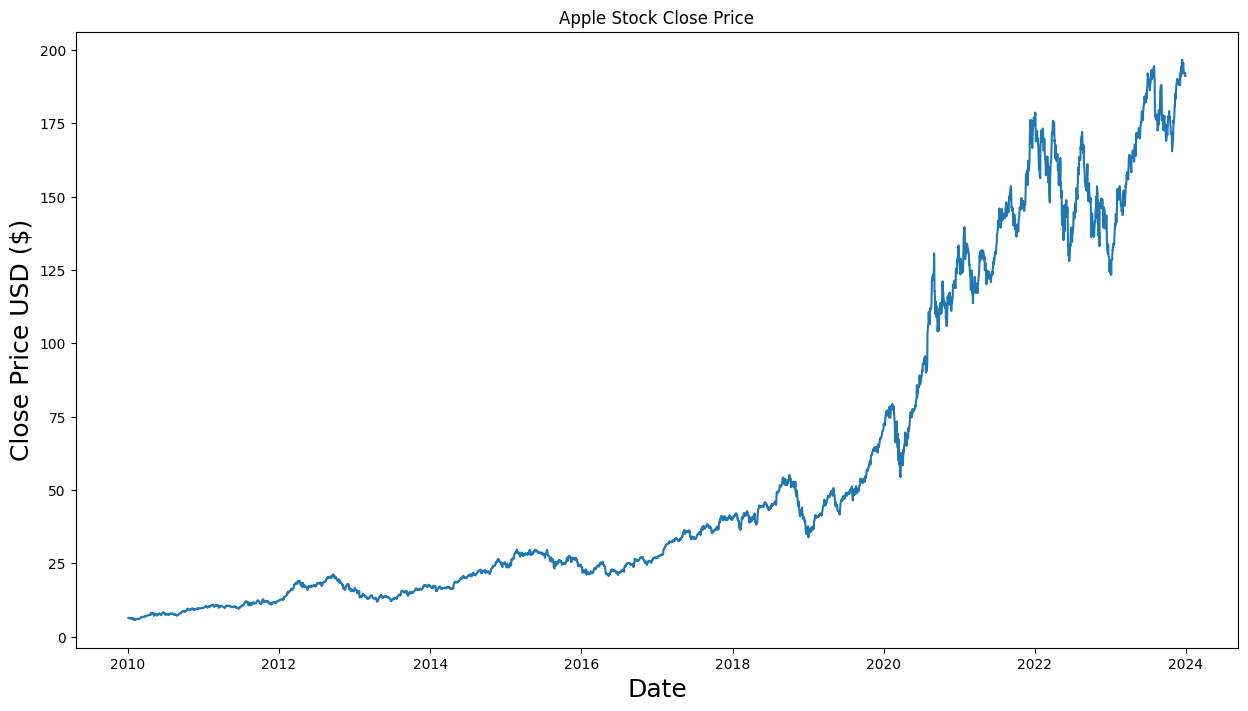

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))
plt.title('Apple Stock Close Price')
plt.plot(aapl_df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [22]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Get the 'Close' column values
close_prices = aapl_df['Close'].values
# Reshape the data to be a 2D array
dataset = close_prices.reshape(-1, 1)
# Get the number of rows to train the model on (80% of the data)
training_data_len = int(np.ceil( len(dataset) * .8 ))

# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [23]:
# Create the training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [24]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences= False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2758/2758 ━━━━━━━━━━━━━━━━━━━━ 67s 23ms/step - loss: 0.0015


In [25]:
# Create the testing data set
# Create a new array containing scaled values from index 2818 to 3522
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

In [26]:
# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print(f'Root Mean Squared Error: {rmse}')

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Root Mean Squared Error: 5.690413947569325


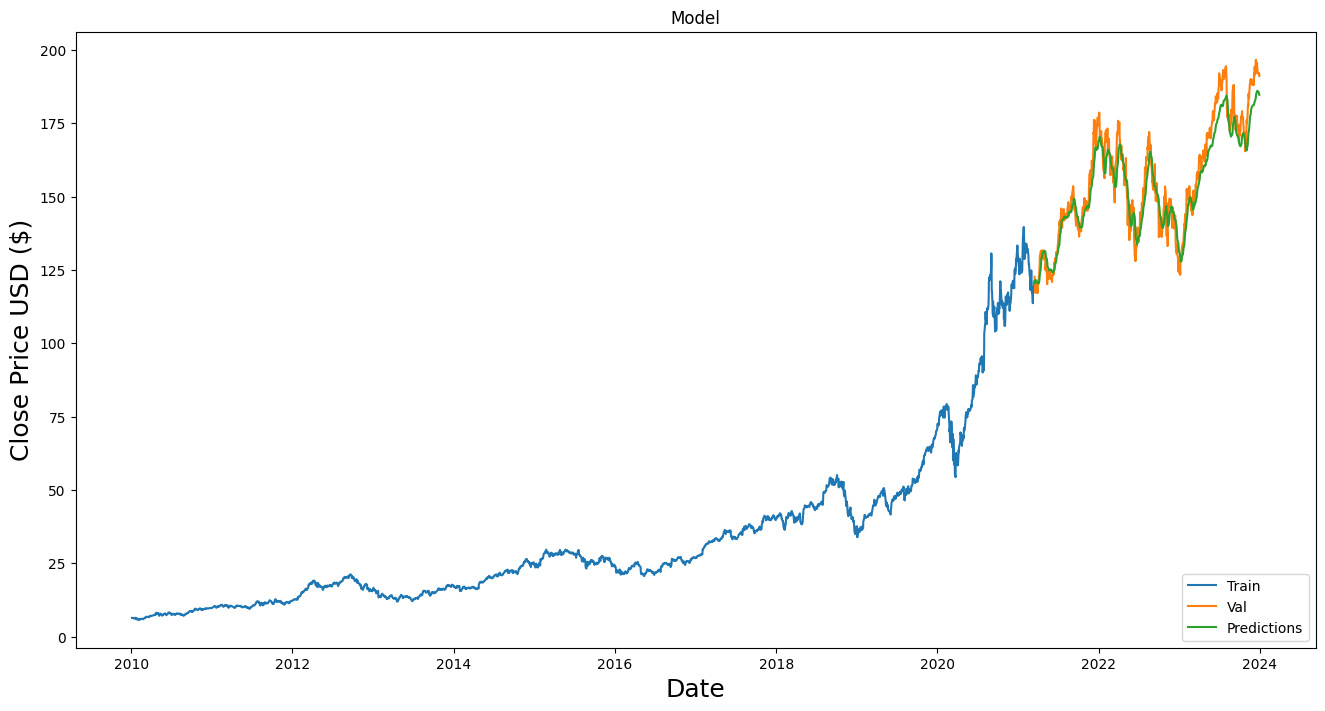

In [28]:
# Plot the data
train = aapl_df[:training_data_len]
valid = aapl_df[training_data_len:]
valid = valid.assign(Predictions = predictions)
# Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

### Project Summary: Stock Price Forecasting using LSTMs

This project demonstrates a complete workflow for time series forecasting, specifically for predicting the stock price of Apple (AAPL). The goal was to build a model that could learn from historical price data and make accurate predictions about future prices.

**1. Data Acquisition and Preparation:**

*   We started by acquiring historical stock data for Apple from Yahoo Finance using the `yfinance` library.
*   The data was then preprocessed to prepare it for the model. This involved:
    *   **Scaling:** We used `MinMaxScaler` to scale the 'Close' price data to a range between 0 and 1. This is a crucial step for neural networks as it helps to stabilize the training process and improve convergence.
    *   **Creating Sequences:** We transformed the data into sequences of 60 time steps. This means that for each prediction, the model looks at the previous 60 days of data. This is a common technique for time series forecasting as it allows the model to learn from the recent trend of the data.

**2. Model Architecture:**

*   We used a Long Short-Term Memory (LSTM) network, which is a type of Recurrent Neural Network (RNN) that is well-suited for time series data. LSTMs are able to learn long-term dependencies in the data, which is important for stock price prediction as there can be trends that span over long periods of time.
*   Our model consisted of two LSTM layers, followed by two Dense layers. The first LSTM layer has `return_sequences=True` which means it returns the full sequence of outputs to the next layer. The second LSTM layer has `return_sequences=False` which means it only returns the last output in the sequence. This is a common architecture for LSTMs as it allows the model to learn from the entire sequence and then make a single prediction.

**3. Training and Evaluation:**

*   The model was trained using the Adam optimizer and the mean squared error (MSE) loss function. We trained the model for a single epoch to demonstrate the process, but in a real-world scenario, we would likely train for more epochs and use techniques like early stopping to prevent overfitting.
*   After training, we evaluated the model's performance on the test set using the Root Mean Squared Error (RMSE). The RMSE gives us a measure of how far off our predictions are from the actual values, in the same units as the original data (in this case, USD).

**4. Results and Conclusion:**

*   The final plot shows that the model was able to capture the general trend of the stock price, but it did not perfectly predict the daily fluctuations. This is expected, as stock prices are notoriously difficult to predict with perfect accuracy.
*   This project serves as a solid foundation for further exploration into time series forecasting. There are many ways to improve upon this model, such as by tuning the hyperparameters, adding more features, or using more advanced models.

Overall, this project demonstrates a practical application of LSTMs for time series forecasting and highlights the key steps involved in building and evaluating a machine learning model.